# <span style="color:blue">Project title/4: "Forecasting the monthly average retail price of steak in Canada</span>

## <span style="color:brown">1. Data Collection & Project Presentation</span>

<p>For this project, we’ll use the historical monthly average retail price of food in Canada,<b>from 1995 to 2022</b>. The dataset, titled “Monthly average retail prices for food and other selected products,” is available for download from Statistics Canada
    here: <a href="www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810000201">Statistics Canada</a>.</p>
    <p>In the dataset provided, we have monthly average retail prices for a diverse range of 52 goods, including items like 1 kilogram of round steak, a dozen eggs, 60 grams of deodorant, and gasoline, among others. The prices are denoted in Canadian dollars and cover the time period from January 1995 to February 2022. Our primary objective for this project is to concentrate on predicting the future price of 1 kilogram of round steak.
</p><br>

<p><b>The objective of this project</b> is to create a model that can forecast the monthly average retail price of 1 kg of round steak over <b>the next 12 months, meaning up to February 2023</b>.</p>

## <span style="color:brown">2. Data Wrangling</span>

In [1]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.plot import plot_yearly, plot_weekly
from prophet.plot import add_changepoints_to_plot
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load the data in the jupyter notebook interface

df = pd.read_csv(r'C:\Users\HP\pyfold\data_ts\retail_steak_price_ca.csv')
df.head()

,Products 5,"Round steak, 1 kilogram"
0,1/1/1995,10.17
1,1/2/1995,10.29
2,1/3/1995,10.12
3,1/4/1995,10.38
4,1/5/1995,10.00


In [3]:
# let's rename the columns

df.rename(columns={'Products 5' :'Date', 'Round steak, 1 kilogram':'price'}, inplace=True)

df.head()

,Date,price
0,1/1/1995,10.17
1,1/2/1995,10.29
2,1/3/1995,10.12
3,1/4/1995,10.38
4,1/5/1995,10.00


In [4]:
# let's check the shape of the new dataframe

df.shape

(326, 2)

In [5]:
# let's check again for missing values
df.isna().sum()

Date     0
price    0
dtype: int64

In [6]:
# let's check the data type of each variable
df.dtypes

Date      object
price    float64
dtype: object

In [7]:
# let's convert each variable to the correct data type

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df

,Date,price
0,1995-01-01,10.17
1,1995-02-01,10.29
2,1995-03-01,10.12
3,1995-04-01,10.38
4,1995-05-01,10.00
...,...,...
321,2021-10-01,20.34
322,2021-11-01,19.77
323,2021-12-01,19.66
324,2022-01-01,20.03


In [8]:
# let's check again the data type of each variable
df.dtypes

Date     datetime64[ns]
price           float64
dtype: object

## <span style="color:brown">3. Modelling with Prophet</span>

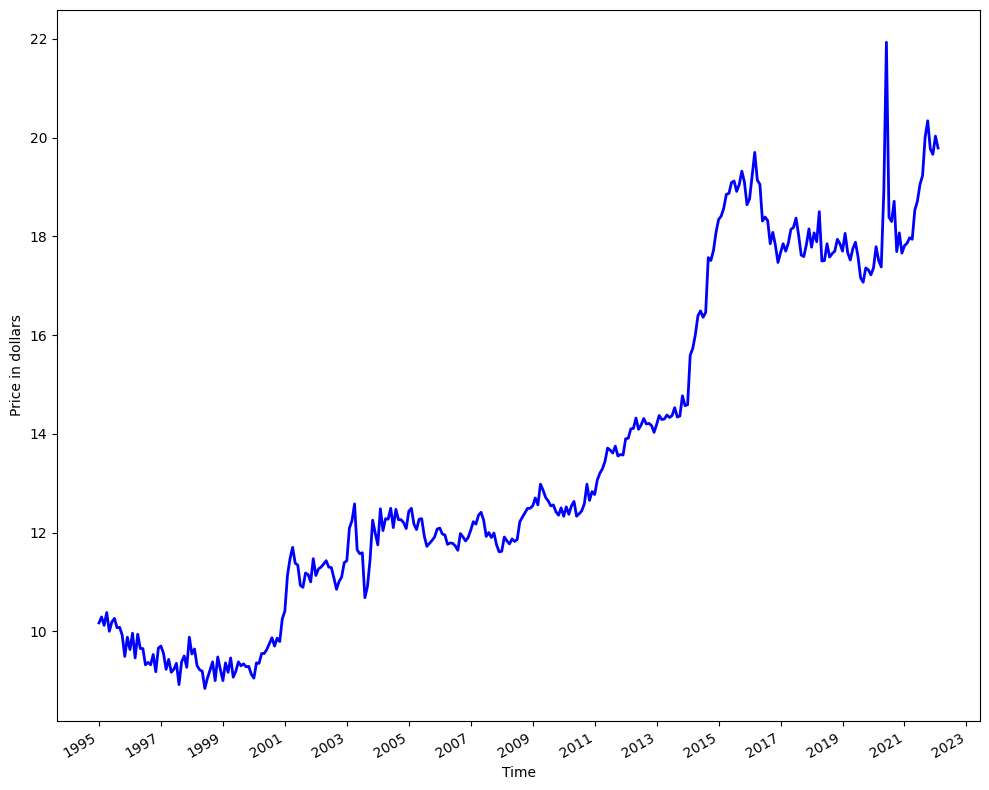

In [9]:
# let's plot the series for observation purpose

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['price'], ls='-', lw=2, color='blue')

ax.set_xlabel('Time')
ax.set_ylabel('Price in dollars')

plt.xticks(np.arange(0, 360, 24), np.arange(1995, 2025, 2))

fig.autofmt_xdate()
plt.tight_layout()

In [10]:
# change the columns names as per Prophet naming convention 

df.columns = ['ds', 'y']

df.head()

,ds,y
0,1995-01-01,10.17
1,1995-02-01,10.29
2,1995-03-01,10.12
3,1995-04-01,10.38
4,1995-05-01,10.00


In [11]:
# let's split the dataset into train and test set

train = df[:-36]
test = df[-36:]

print(len(train), len(test))

290 36


In [12]:
# let's operate the parameters tuning


param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

mses = []


for param in params:
    m = Prophet(**param, seasonality_mode='additive')
    m.add_country_holidays(country_name='CA')
    m.fit(train)
    
    df_cv = cross_validation(m, initial='3650 days', period='180 days', horizon='1095 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mses.append(df_p['mse'].values[0])
    
tuning_results = pd.DataFrame(params)
tuning_results['mse'] = mses

21:46:21 - cmdstanpy - INFO - Chain [1] start processing
21:46:22 - cmdstanpy - INFO - Chain [1] done processing
21:46:37 - cmdstanpy - INFO - Chain [1] start processing
21:46:38 - cmdstanpy - INFO - Chain [1] done processing
21:46:54 - cmdstanpy - INFO - Chain [1] start processing
21:46:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:07 - cmdstanpy - INFO - Chain [1] start processing
21:47:07 - cmdstanpy - INFO - Chain [1] done processing
21:47:20 - cmdstanpy - INFO - Chain [1] start processing
21:47:20 - cmdstanpy - INFO - Chain [1] done processing
21:47:29 - cmdstanpy - INFO - Chain [1] start processing
21:47:29 - cmdstanpy - INFO - Chain [1] done processing
21:47:37 - cmdstanpy - INFO - Chain [1] start processing
21:47:37 - cmdstanpy - INFO - Chain [1] done processing
21:47:46 - cmdstanpy - INFO - Chain [1] start processing
21:47:46 - cmdstanpy - INFO - Chain [1] done processing
21:47:55 - cmdstanpy - INFO - Chain [1] start processing
21:47:55 - cmdstanpy - INFO - Chain [1]

In [13]:
best_params = params[np.argmin(mses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [14]:
# fit the model with the best parameters

m = Prophet(**best_params, seasonality_mode='multiplicative')
m.add_country_holidays(country_name='Canada')
m.fit(train)

21:54:00 - cmdstanpy - INFO - Chain [1] start processing
21:54:00 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# let's forecast the steak price for the last 36 months

future = m.make_future_dataframe(periods=36, freq='M')

forecast = m.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
321,2021-09-30,18.663852,16.814899,20.691031
322,2021-10-31,18.646587,16.684028,20.831104
323,2021-11-30,18.666136,16.545564,20.715279
324,2021-12-31,18.698488,16.442301,20.882048
325,2022-01-31,18.976973,16.680580,21.482197


In [17]:
# let's add the forecasted values to the test set

test[['yhat', 'yhat_lower', 'yhat_upper']] = forecast[['yhat', 'yhat_lower', 'yhat_upper']]

test.head()

,ds,y,yhat,yhat_lower,yhat_upper
290,2019-03-01,17.67,18.428332,17.822131,19.012116
291,2019-04-01,17.52,18.599235,17.993733,19.208166
292,2019-05-01,17.75,18.474482,17.866406,19.059207
293,2019-06-01,17.88,18.421992,17.778923,19.027667
294,2019-07-01,17.59,18.387713,17.701544,18.974122


In [18]:
# let's apply a baseline forecast as a benchmark

test['baseline'] = train['y'][-36:].values

test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline
290,2019-03-01,17.67,18.428332,17.822131,19.012116,19.70
291,2019-04-01,17.52,18.599235,17.993733,19.208166,19.14
292,2019-05-01,17.75,18.474482,17.866406,19.059207,19.05
293,2019-06-01,17.88,18.421992,17.778923,19.027667,18.31
294,2019-07-01,17.59,18.387713,17.701544,18.974122,18.39


In [19]:
# let's evaluate both models
from sklearn.metrics import mean_absolute_error

prophet_mae = mean_absolute_error(test['y'], test['yhat'])
baseline_mae = mean_absolute_error(test['y'], test['baseline'])

print(prophet_mae)
print('------------')
print(baseline_mae)

0.8875768959506036
------------
1.0011111111111113


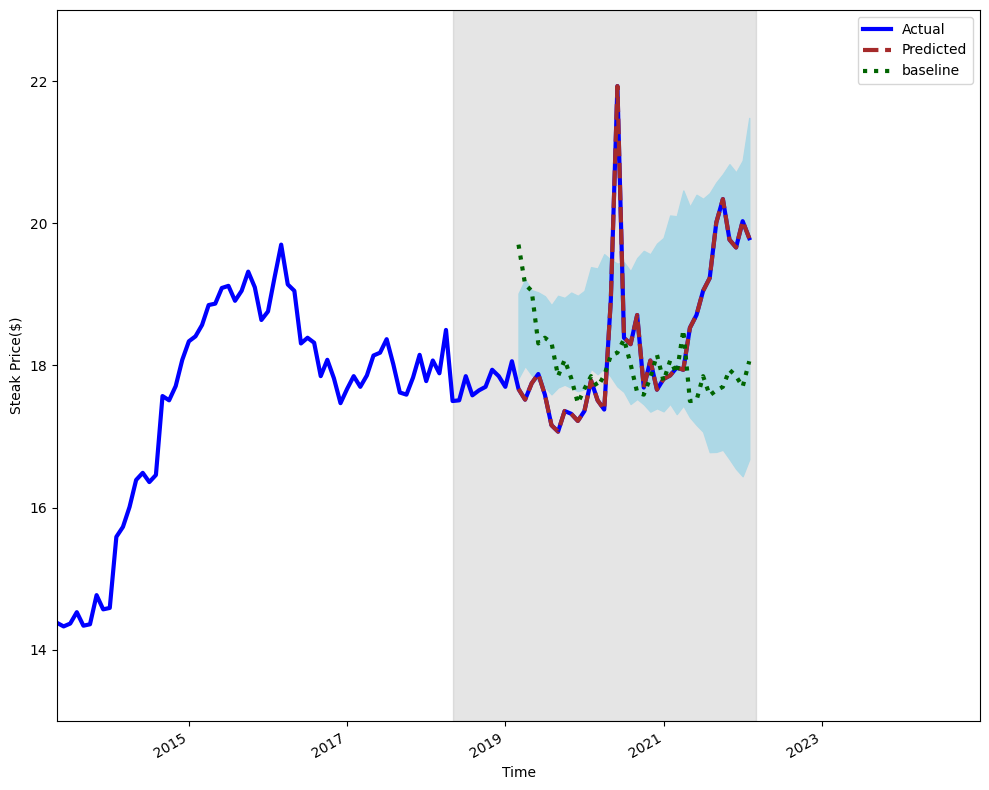

In [20]:
# let's plot the forecasted and the actual values

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['y'], ls='-', lw=3, color='blue', label='Actual')
ax.plot(test['y'], ls='--', lw=3, color='brown', label='Predicted')
ax.plot(test['baseline'], ls=':', lw=3, color='darkgreen', label='baseline')

ax.set_xlabel('Time')
ax.set_ylabel('Steak Price($)')

ax.legend(loc='best')
ax.axvspan(280, 326, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 360, 24), np.arange(1995, 2025, 2))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
ax.set_xlim(220, 360)
ax.set_ylim(13, 23)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic.png', dpi=300)

## <span style="color:brown">4. Modelling with SARIMA</span>

In [21]:
# let's important the necessary libraries
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Text(0, 0.5, 'Residuals')

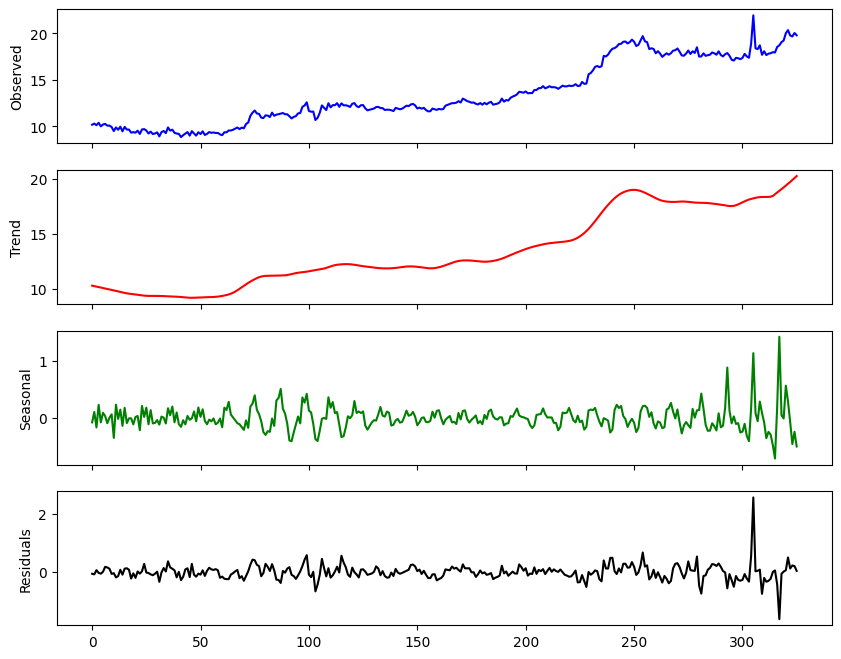

In [22]:
# let's decompose the series to check each component

decomposition = STL(df['y'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed, 'b-')
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend, 'r-')
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal, 'g-')
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid, 'k-')
ax4.set_ylabel('Residuals')

In [23]:
# let's check the stationarity with the Augmented Dickey Fuller test (ADF) 

ad_fuller_res = adfuller(df['y'])
print(f'ADF Statistic: {ad_fuller_res[0]}')
print(f'p-value: {ad_fuller_res[1]}')

ADF Statistic: 0.23531027344420638
p-value: 0.9741739375968131


p-value is still greater than 0.05, so let's perform a one-order differencing

In [24]:
diff_df = np.diff(df['y'])

ad_fuller_res = adfuller(diff_df)
print(f'ADF Statistic: {ad_fuller_res[0]}')
print(f'p-value: {ad_fuller_res[1]}')

ADF Statistic: -16.94550732135996
p-value: 9.546847704827569e-30


The series is now stationary!

In [25]:
# let's perform a parameter grid search with pmdarima to find out the best parameters (p,d,q) (P, D, Q)
from pmdarima import auto_arima

y = df['y']

# Define the order of seasonal differencing, denoted by (p, d, q, P, D, Q, m)
# p: order of the AR (autoregressive) component
# d: order of differencing
# q: order of the MA (moving average) component
# P: order of the seasonal AR component
# D: order of seasonal differencing
# Q: order of the seasonal MA component
# m: number of time steps in each seasonal period (e.g., m=12 for monthly data with yearly seasonality)


# Use auto_arima to determine the best hyperparameters
model = auto_arima(y, seasonal=True, m=12, 
                   start_p=0, start_q=0, max_p=5, max_q=5, 
                   start_P=0, start_Q=0, max_P=5, max_Q=5, 
                   stepwise=True, trace=True, 
                   information_criterion='aic')

# Print the summary of the best model
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=318.106, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=303.237, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=296.914, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=317.951, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=297.758, Time=0.09 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=298.050, Time=0.50 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=298.242, Time=0.71 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=297.099, Time=0.23 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=300.012, Time=2.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=317.735, Time=0.17 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=297.668, Time=0.45 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=296.660, Time=0.65 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=297.356, Time=0.25 sec
 ARIMA(0,1,2)(1,0,1)[12] intercept   : AIC=297.862, Time=1.06 sec
 ARIMA(0,1,2)(0,0,2)[12] intercep

In [26]:
# let's fit the model

best_model = SARIMAX(train['y'], order=(0,1,3), seasonal_order=(0,0,1,12), simple_differencing=False)

sarima_model_auto =  best_model.fit(disp=False)

print(sarima_model_auto.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  290
Model:             SARIMAX(0, 1, 3)x(0, 0, [1], 12)   Log Likelihood                 -30.906
Date:                              Mon, 17 Jul 2023   AIC                             71.812
Time:                                      21:56:22   BIC                             90.144
Sample:                                           0   HQIC                            79.157
                                              - 290                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1811      0.054     -3.367      0.001      -0.287      -0.076
ma.L2          0.06

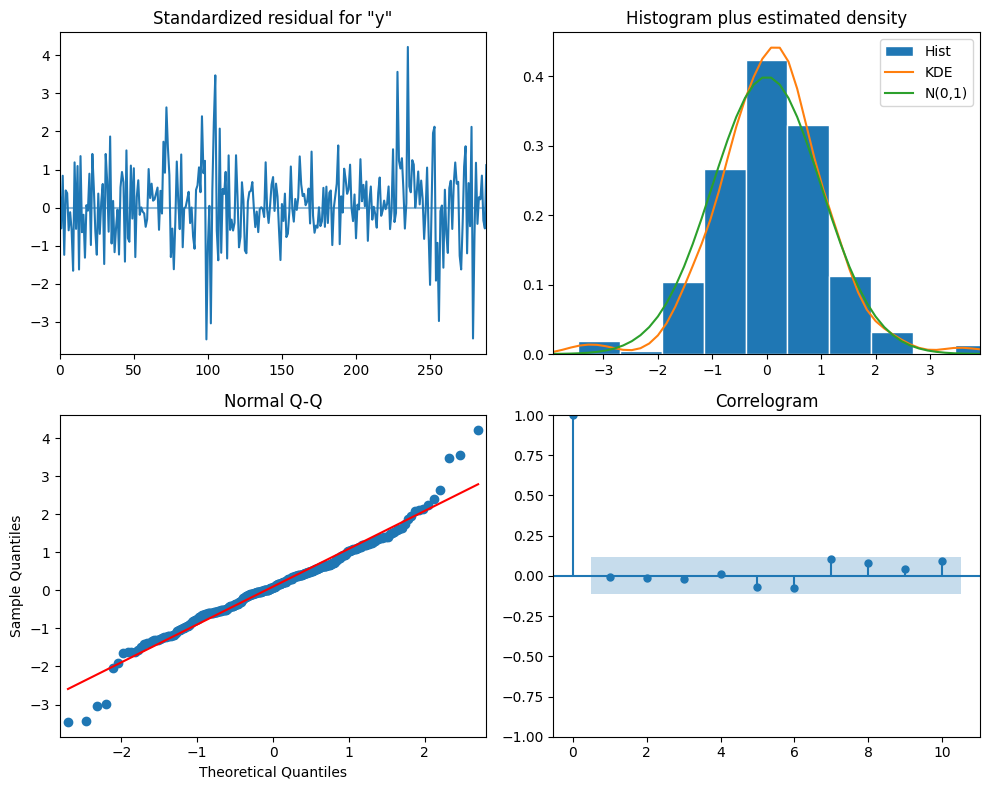

In [27]:
# let's analyze the residuals qualitatively

sarima_model_auto.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the residuals are generally close to white noise. the Q-Q plots exhibits a line close to y=x. The historgam shows a distribution which is similar to a normal distribution. The correlogram shows no autocorrelation after lag 0

In [28]:
# let's analyse quantitatively the residuals by performing the Ljung Box Statistics test

Residuals = sarima_model_auto.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.011110,0.916054
2,0.092668,0.954723
3,0.146588,0.985713
4,0.378072,0.984233
5,0.383046,0.995784
6,0.396343,0.998881
7,0.397668,0.999742
8,0.418853,0.999932
9,0.437919,0.999983
10,0.611497,0.999983


the p-values are everywhere greater than 0.05, meaning we cannot reject the null hypothesis that states that the residuals are independently distributed. Therefore, they are uncorrelated!

In [29]:
# let's forecast the test set 

pred_sarima = sarima_model_auto.get_prediction(290, 325).predicted_mean

test.loc[:,'pred_sarima'] = pred_sarima
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline,pred_sarima
290,2019-03-01,17.67,18.428332,17.822131,19.012116,19.70,17.975036
291,2019-04-01,17.52,18.599235,17.993733,19.208166,19.14,18.044643
292,2019-05-01,17.75,18.474482,17.866406,19.059207,19.05,17.960837
293,2019-06-01,17.88,18.421992,17.778923,19.027667,18.31,17.960727
294,2019-07-01,17.59,18.387713,17.701544,18.974122,18.39,17.992134


In [30]:
# let's evaluate both models
from sklearn.metrics import mean_absolute_error

sarima_mae = mean_absolute_error(test['y'], test['pred_sarima'])

print(sarima_mae)

0.8250115983583748


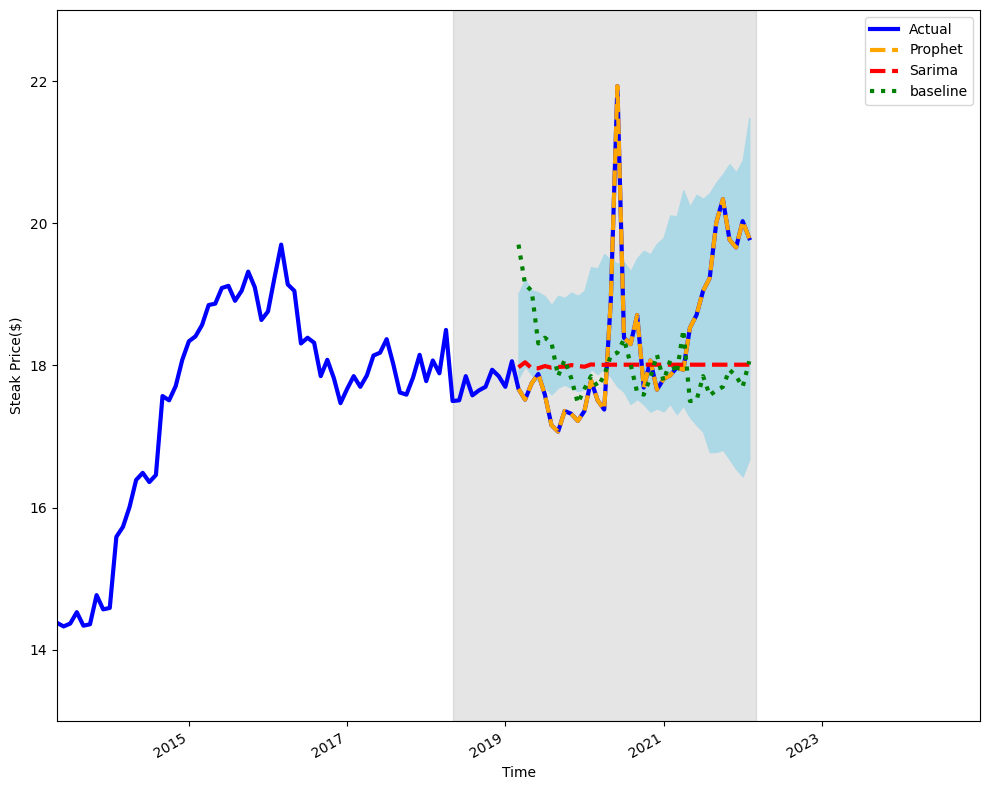

In [31]:
# let's plot the forecasted values for both methods and the actual values  

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['y'], ls='-', lw=3, color='blue', label='Actual')
ax.plot(test['y'], ls='--', lw=3, color='orange', label='Prophet')
ax.plot(test['pred_sarima'], ls='--', lw=3, color='red', label='Sarima')
ax.plot(test['baseline'], ls=':', lw=3, color='green', label='baseline')

ax.set_xlabel('Time')
ax.set_ylabel('Steak Price($)')

ax.legend(loc='best')
ax.axvspan(280, 326, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 360, 24), np.arange(1995, 2025, 2))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
ax.set_xlim(220, 360)
ax.set_ylim(13, 23)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic55.png', dpi=300)

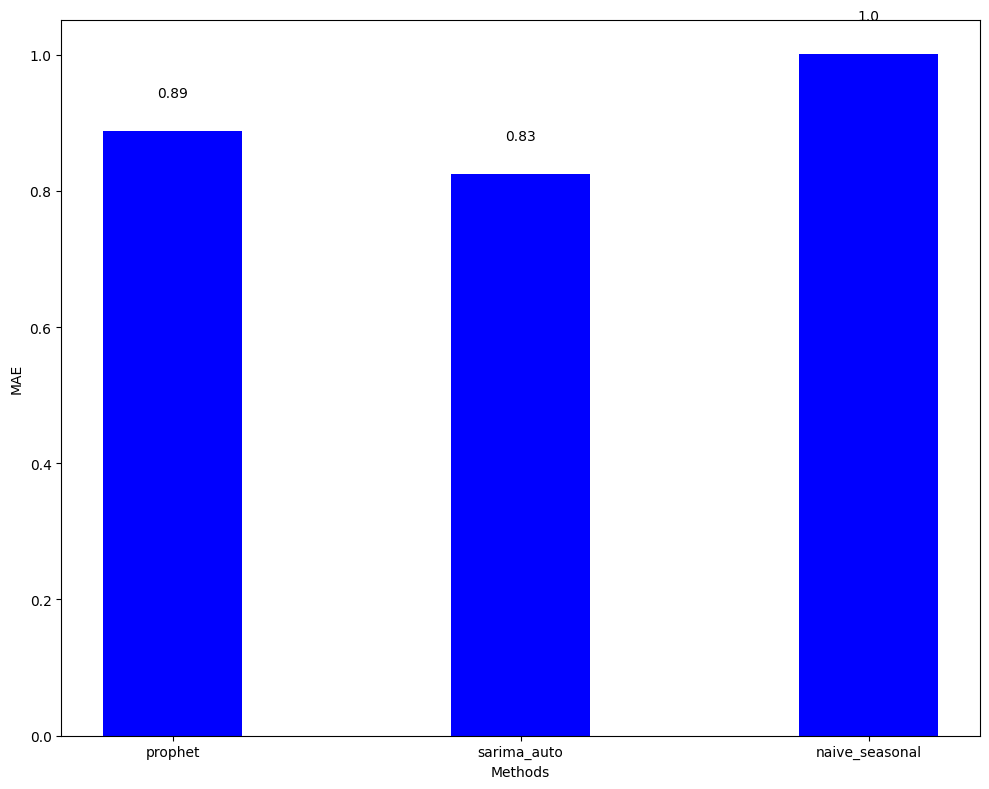

In [32]:
# let's plot the performance of both methods

fig, ax = plt.subplots(figsize=(10,8))

x = ['prophet', 'sarima_auto', 'naive_seasonal']
y = [prophet_mae, sarima_mae, baseline_mae]

ax.bar(x, y, width=0.4, color='blue')
ax.set_xlabel('Methods')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()
plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic56.png', dpi=300)

In [33]:
#let's select the appropriate model based upon the lowest Akaike Information Criteria (AIC) 
#we define a fucntion to perform a grid search

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [34]:
# let's create a list of possible values of the parameters p, q, P and Q

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d=1
D=0
s=12  #the data is recorded monthly

order_list =  list(product(ps, qs, Ps, Qs))

result_df = optimize_SARIMA(train['y'], order_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 1, 1)",57.419010
1,"(1, 0, 1, 1)",59.485103
2,"(0, 1, 1, 1)",59.689841
3,"(3, 2, 1, 1)",59.895883
4,"(1, 2, 1, 1)",60.666857
...,...,...
251,"(0, 0, 0, 2)",78.288731
252,"(3, 3, 3, 0)",78.374747
253,"(0, 0, 0, 0)",78.913358
254,"(0, 0, 0, 3)",79.751275


In [35]:
# let's fit the model

best_model2 = SARIMAX(train['y'], order=(2,1,3), seasonal_order=(1,0,1,12), simple_differencing=False)

sarima_model =  best_model2.fit(disp=False)

print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  290
Model:             SARIMAX(2, 1, 3)x(1, 0, [1], 12)   Log Likelihood                 -20.710
Date:                              Mon, 17 Jul 2023   AIC                             57.419
Time:                                      22:06:48   BIC                             86.750
Sample:                                           0   HQIC                            69.172
                                              - 290                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2326      0.042     29.099      0.000       1.150       1.316
ar.L2         -0.92

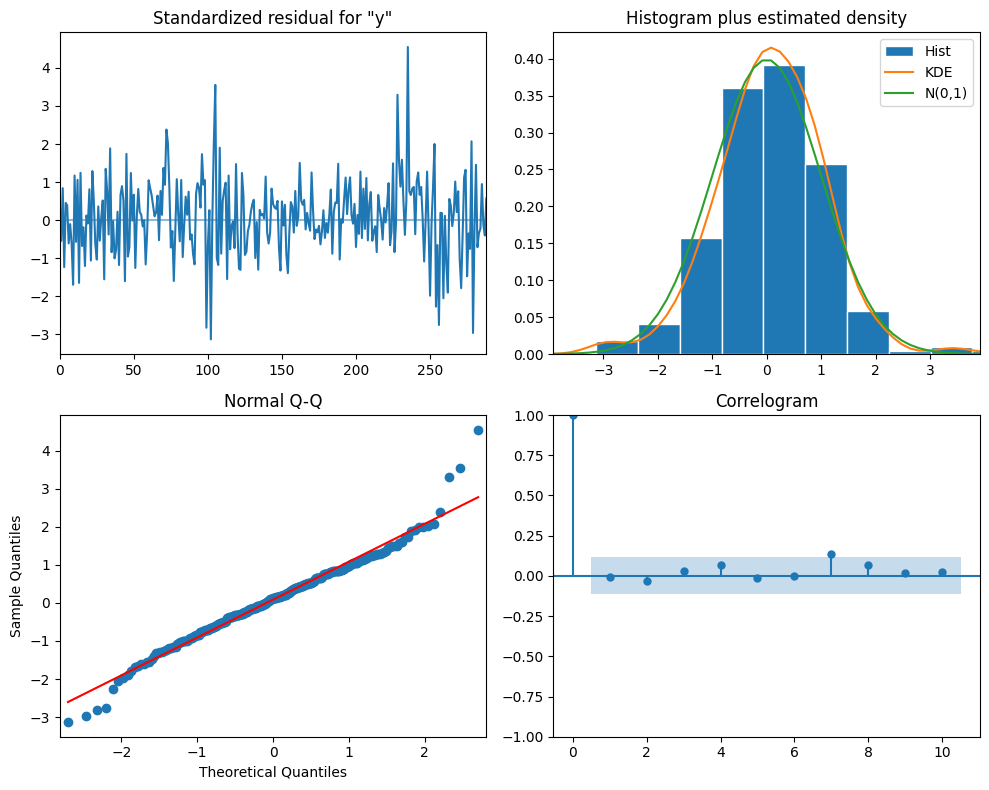

In [36]:
# let's analyze the residuals qualitatively

sarima_model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()
plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic59.png', dpi=300)

the residuals resemble white noise

In [37]:
# let's analyse quantitatively the residuals by performing the Ljung Box Statistics test

Residuals = sarima_model.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.011801,0.913492
2,0.112092,0.945496
3,0.251171,0.968934
4,0.364184,0.985303
5,0.373000,0.996041
6,0.384826,0.998972
7,0.392278,0.999753
8,0.407113,0.999939
9,0.459411,0.999979
10,0.857762,0.999915


we cannot reject the null hypothesis as well!

In [38]:
# let's forecast the test set 

pred_sarima2 = sarima_model.get_prediction(290, 325).predicted_mean

test.loc[:,'pred_sarima2'] = pred_sarima2
test.head()

,ds,y,yhat,yhat_lower,yhat_upper,baseline,pred_sarima,pred_sarima2
290,2019-03-01,17.67,18.428332,17.822131,19.012116,19.70,17.975036,18.014740
291,2019-04-01,17.52,18.599235,17.993733,19.208166,19.14,18.044643,18.176975
292,2019-05-01,17.75,18.474482,17.866406,19.059207,19.05,17.960837,18.151536
293,2019-06-01,17.88,18.421992,17.778923,19.027667,18.31,17.960727,18.117639
294,2019-07-01,17.59,18.387713,17.701544,18.974122,18.39,17.992134,18.065193


In [39]:
# let's evaluate both models
from sklearn.metrics import mean_absolute_error

sarima2_mae = mean_absolute_error(test['y'], test['pred_sarima2'])

print(sarima2_mae)

0.7681864566092353


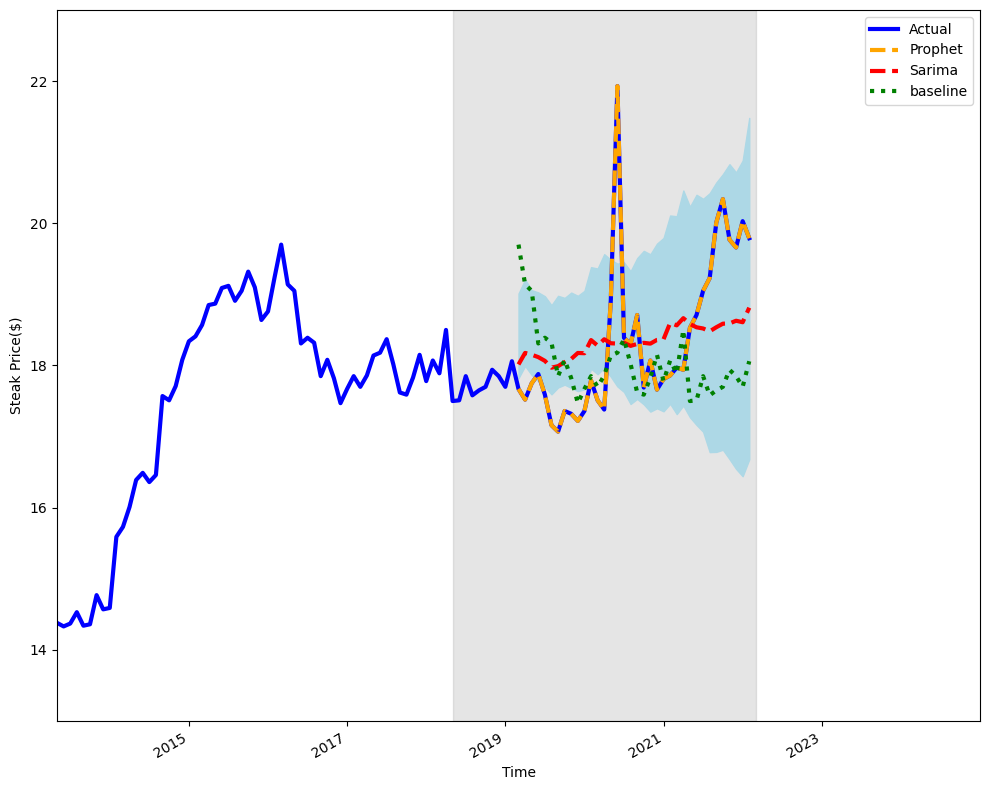

In [40]:
# let's plot the forecasted values for both methods and the actual values  

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['y'], ls='-', lw=3, color='blue', label='Actual')
ax.plot(test['y'], ls='--', lw=3, color='orange', label='Prophet')
ax.plot(test['pred_sarima2'], ls='--', lw=3, color='red', label='Sarima')
ax.plot(test['baseline'], ls=':', lw=3, color='green', label='baseline')

ax.set_xlabel('Time')
ax.set_ylabel('Steak Price($)')

ax.legend(loc='best')
ax.axvspan(280, 326, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 360, 24), np.arange(1995, 2025, 2))
plt.fill_between(x=test.index, y1=test['yhat_lower'], y2=test['yhat_upper'], color='lightblue')
ax.set_xlim(220, 360)
ax.set_ylim(13, 23)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic58.png', dpi=300)

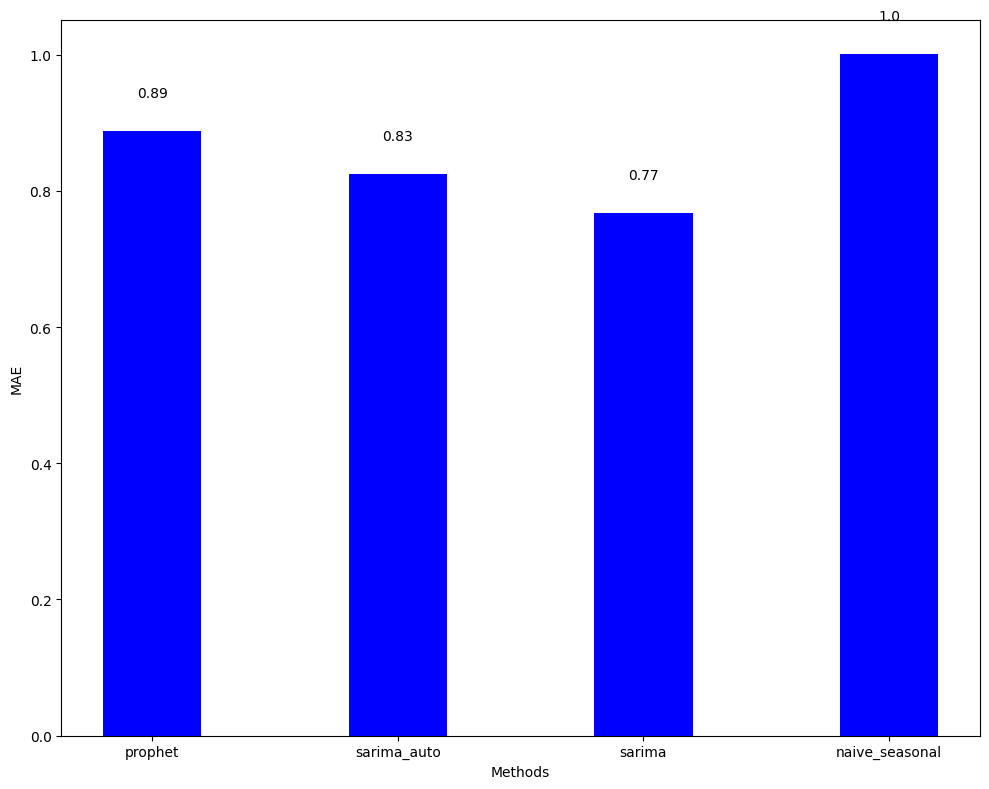

In [41]:
# let's plot the performance of all methods with the best sarima

fig, ax = plt.subplots(figsize=(10,8))

x = ['prophet', 'sarima_auto', 'sarima','naive_seasonal']
y = [prophet_mae, sarima_mae, sarima2_mae, baseline_mae]

ax.bar(x, y, width=0.4, color='blue')
ax.set_xlabel('Methods')
ax.set_ylabel('MAE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

<p>Sarima method outperformed the prophet one in forecasting the last 36 months of steak price in Canada! It has the lowest out of sample error. Therefore, <b>we will use Sarima to forecast the steak price up to February 2024!</b></p>

## <span style="color:brown">5. Forecasting up to 2023!</span>

In [42]:
# let's create a list of possible values of the parameters p, q, P and Q 
# and fit a Sarima model using the entire dataset this time

ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

d=1
D=0
s=12  #the data is recorded monthly

order_list =  list(product(ps, qs, Ps, Qs))

result_df = optimize_SARIMA(df['y'], order_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 3, 0, 0)",294.580316
1,"(2, 0, 2, 2)",294.826770
2,"(2, 0, 0, 1)",294.979120
3,"(2, 3, 1, 0)",295.003180
4,"(2, 0, 1, 0)",295.040297
...,...,...
251,"(0, 0, 2, 1)",320.379364
252,"(0, 0, 3, 0)",320.379669
253,"(0, 0, 1, 2)",320.389702
254,"(0, 0, 2, 2)",321.235942


In [43]:
# let's fit the model

best_model_fit = SARIMAX(df['y'], order=(2,1,3), seasonal_order=(0,0,0,12), simple_differencing=False)

sarima_model_fit =  best_model_fit.fit(disp=False)

print(sarima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  326
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -141.290
Date:                Mon, 17 Jul 2023   AIC                            294.580
Time:                        22:25:29   BIC                            317.283
Sample:                             0   HQIC                           303.641
                                - 326                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0216      0.029     -0.753      0.451      -0.078       0.035
ar.L2         -0.9900      0.021    -46.374      0.000      -1.032      -0.948
ma.L1         -0.2277      0.050     -4.569      0.0

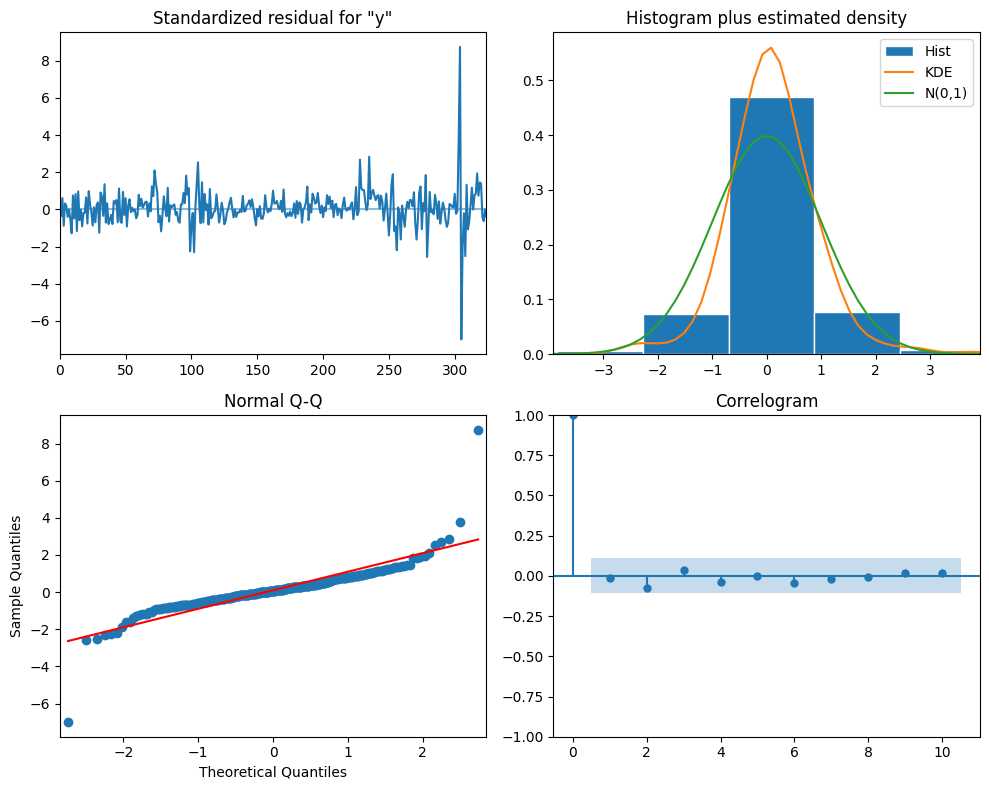

In [44]:
# let's analyze the residuals qualitatively

sarima_model_fit.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

The residuals look like white noise!

In [45]:
# let's analyse quantitatively the residuals by performing the Ljung Box Statistics test

Residuals = sarima_model_fit.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.001282,0.971436
2,0.395677,0.820502
3,0.590671,0.898565
4,1.050563,0.902034
5,1.059625,0.957615
6,1.106206,0.981264
7,1.235531,0.990086
8,1.241218,0.996218
9,1.280460,0.998471
10,1.601748,0.998582


We cannot reject the null hypothesis, meaning that the residuals are indenpendently distributed and uncorrelated

In [46]:
# let's forecast upt to February 2023

future_pred = sarima_model_fit.get_prediction(326, 337).predicted_mean

predictions = pd.DataFrame({'Predictions': future_pred})

predictions

,Predictions
326,19.501450
327,19.607887
328,19.918347
329,19.806267
330,19.501346
331,19.618892
332,19.918212
333,19.795376
334,19.501715
335,19.629665


In [47]:
# Use the get_forecast method to generate future predictions and confidence intervals

forecast_periods = 12
forecast = sarima_model_fit.get_forecast(steps=forecast_periods)
predicted_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

print(predicted_values)
print('-------------')
print(confidence_intervals)

326    19.501450
327    19.607887
328    19.918347
329    19.806267
330    19.501346
331    19.618892
332    19.918212
333    19.795376
334    19.501715
335    19.629665
336    19.917614
337    19.784724
Name: predicted_mean, dtype: float64
-------------
       lower y    upper y
326  18.774580  20.228320
327  18.698993  20.516782
328  18.858569  20.978125
329  18.596107  21.016427
330  18.157617  20.845075
331  18.168768  21.069015
332  18.368616  21.467808
333  18.139145  21.451607
334  17.745929  21.257500
335  17.791295  21.468035
336  17.999454  21.835774
337  17.779326  21.790121


In [48]:
# let's combine all the prediction in a single dataframe

pred_df = pd.concat([predictions, confidence_intervals], axis=1)

pred_df

,Predictions,lower y,upper y
326,19.501450,18.774580,20.228320
327,19.607887,18.698993,20.516782
328,19.918347,18.858569,20.978125
329,19.806267,18.596107,21.016427
330,19.501346,18.157617,20.845075
331,19.618892,18.168768,21.069015
332,19.918212,18.368616,21.467808
333,19.795376,18.139145,21.451607
334,19.501715,17.745929,21.257500
335,19.629665,17.791295,21.468035


In [49]:
pred_df.columns = ['Predictions', 'lower_y', 'upper_y']
pred_df

,Predictions,lower_y,upper_y
326,19.501450,18.774580,20.228320
327,19.607887,18.698993,20.516782
328,19.918347,18.858569,20.978125
329,19.806267,18.596107,21.016427
330,19.501346,18.157617,20.845075
331,19.618892,18.168768,21.069015
332,19.918212,18.368616,21.467808
333,19.795376,18.139145,21.451607
334,19.501715,17.745929,21.257500
335,19.629665,17.791295,21.468035


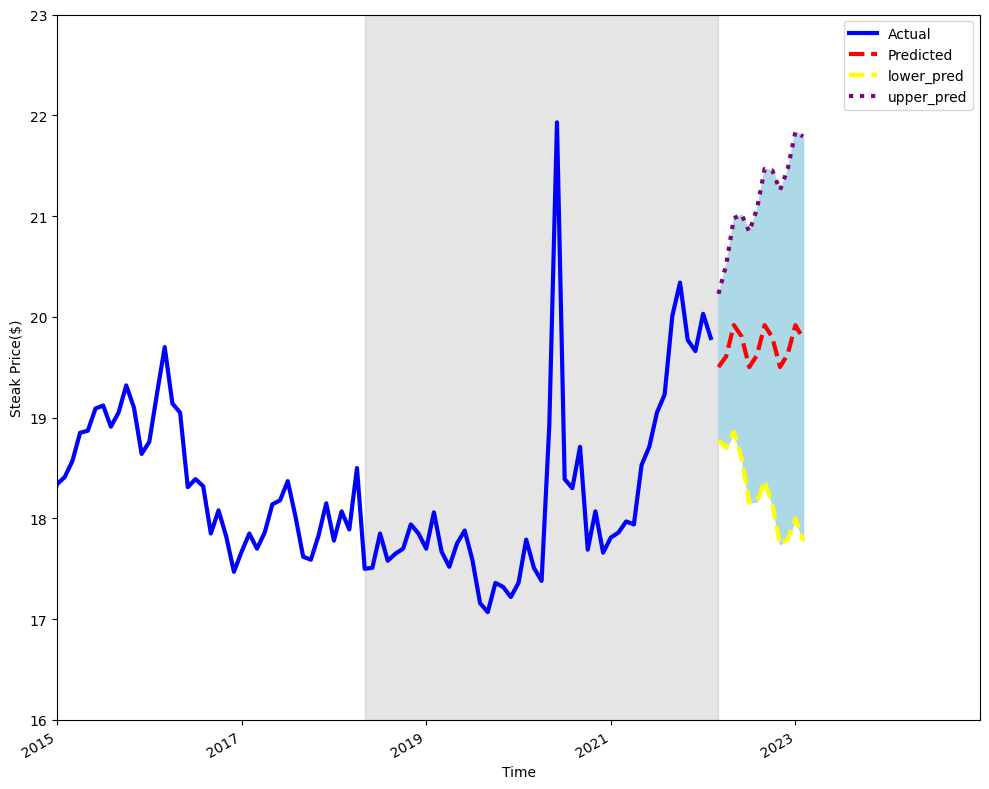

In [50]:
# let's plot the forecasted values for both methods and the actual values  

fig, ax = plt.subplots(figsize=(10,8))

ax.plot(df['y'], ls='-', lw=3, color='blue', label='Actual')
ax.plot(pred_df['Predictions'], ls='--', lw=3, color='red', label='Predicted')
ax.plot(pred_df['lower_y'], ls='--', lw=3, color='yellow', label='lower_pred')
ax.plot(pred_df['upper_y'], ls=':', lw=3, color='purple', label='upper_pred')

ax.set_xlabel('Time')
ax.set_ylabel('Steak Price($)')

ax.legend(loc='best')
ax.axvspan(280, 326, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 360, 24), np.arange(1995, 2025, 2))
plt.fill_between(x=pred_df.index, y1=pred_df['lower_y'], y2=pred_df['upper_y'], color='lightblue')
ax.set_xlim(240, 360)
ax.set_ylim(16, 23)

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('C:\\Users\HP\\Desktop\\Database Project\\figures\\pic57.png', dpi=300)